In [1]:
!pip install -q diffusers==0.25.0 xformers==0.0.23.post1 transformers==4.36.2 torchvision==0.16.2 accelerate==0.26.1 opencv-python==4.9.0.80
!pip install scipy==1.11.4 triton==2.1.0 altair==4.1.0 pandas==2.1.4

  Obtaining dependency information for scipy==1.11.4 from https://files.pythonhosted.org/packages/e0/9e/80e2205d138960a49caea391f3710600895dd8292b6868dc9aff7aa593f9/scipy-1.11.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 727.8/727.8 kB 8.0 MB/s eta 0:00:00a 0:00:01
  Obtaining dependency information for pandas==2.1.4 from https://files.pythonhosted.org/packages/b1/67/aca1f6e215d957d24d0a290321f368503305480268f9617bf625243e9dea/pandas-2.1.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for tzdata>=2022.1 from https://files.pythonhosted.org/packages/65/58/f9c9e6be752e9fcb8b6a0ee9fb87e6e7a1f6bcab2cdc73f02bb7ba91ada0/tzdata-2024.1-py2.py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 46.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [1]:
from typing import Tuple, Union, List
import os

import numpy as np
from PIL import Image

import torch
from diffusers import ControlNetModel
from diffusers.pipelines.controlnet import MultiControlNetModel, StableDiffusionControlNetInpaintPipeline
from diffusers import ControlNetModel, UniPCMultistepScheduler
from transformers import AutoImageProcessor, UperNetForSemanticSegmentation

from colors import ade_palette
from utils import map_colors_rgb

In [5]:
def filter_items(
    colors_list: Union[List, np.ndarray],
    items_list: Union[List, np.ndarray],
    items_to_remove: Union[List, np.ndarray]
) -> Tuple[Union[List, np.ndarray], Union[List, np.ndarray]]:
    """
    Filters items and their corresponding colors from given lists, excluding
    specified items.

    Args:
        colors_list: A list or numpy array of colors corresponding to items.
        items_list: A list or numpy array of items.
        items_to_remove: A list or numpy array of items to be removed.

    Returns:
        A tuple of two lists or numpy arrays: filtered colors and filtered
        items.
    """
    filtered_colors = []
    filtered_items = []
    for color, item in zip(colors_list, items_list):
        if item not in items_to_remove:
            filtered_colors.append(color)
            filtered_items.append(item)
    return filtered_colors, filtered_items

def get_segmentation_pipeline(
) -> Tuple[AutoImageProcessor, UperNetForSemanticSegmentation]:
    """Method to load the segmentation pipeline
    Returns:
        Tuple[AutoImageProcessor, UperNetForSemanticSegmentation]: segmentation pipeline
    """
    image_processor = AutoImageProcessor.from_pretrained(
        "openmmlab/upernet-convnext-small"
    )
    image_segmentor = UperNetForSemanticSegmentation.from_pretrained(
        "openmmlab/upernet-convnext-small"
    )
    return image_processor, image_segmentor


@torch.inference_mode()
@torch.autocast('cuda')
def segment_image(
        image: Image,
        image_processor: AutoImageProcessor,
        image_segmentor: UperNetForSemanticSegmentation
) -> Image:
    """
    Segments an image using a semantic segmentation model.

    Args:
        image (Image): The input image to be segmented.
        image_processor (AutoImageProcessor): The processor to prepare the
            image for segmentation.
        image_segmentor (UperNetForSemanticSegmentation): The semantic
            segmentation model used to identify different segments in the image.

    Returns:
        Image: The segmented image with each segment colored differently based
            on its identified class.
    """
    # image_processor, image_segmentor = get_segmentation_pipeline()
    pixel_values = image_processor(image, return_tensors="pt").pixel_values
    with torch.no_grad():
        outputs = image_segmentor(pixel_values)

    seg = image_processor.post_process_semantic_segmentation(
        outputs, target_sizes=[image.size[::-1]])[0]
    color_seg = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.uint8)
    palette = np.array(ade_palette())
    for label, color in enumerate(palette):
        color_seg[seg == label, :] = color
    color_seg = color_seg.astype(np.uint8)
    seg_image = Image.fromarray(color_seg).convert('RGB')
    return seg_image


def resize_dimensions(dimensions, target_size):
    """ 
    Resize PIL to target size while maintaining aspect ratio 
    If smaller than target size leave it as is
    """
    width, height = dimensions

    # Check if both dimensions are smaller than the target size
    if width < target_size and height < target_size:
        return dimensions

    # Determine the larger side
    if width > height:
        # Calculate the aspect ratio
        aspect_ratio = height / width
        # Resize dimensions
        return (target_size, int(target_size * aspect_ratio))
    else:
        # Calculate the aspect ratio
        aspect_ratio = width / height
        # Resize dimensions
        return (int(target_size * aspect_ratio), target_size)



class ControlNetDesignModel:
    """ Produces random noise images """
    def __init__(self):
        """ Initialize your model(s) here """

        os.environ['HF_HUB_OFFLINE'] = "True"
        controlnet_seg = ControlNetModel.from_pretrained(
            "BertChristiaens/controlnet-seg-room", torch_dtype=torch.float16)

        self.pipe = StableDiffusionControlNetInpaintPipeline.from_pretrained(
            "runwayml/stable-diffusion-inpainting",
            controlnet=controlnet_seg,
            safety_checker=None,
            torch_dtype=torch.float16
        )

        self.pipe.scheduler = UniPCMultistepScheduler.from_config(self.pipe.scheduler.config)
        #self.pipe.enable_xformers_memory_efficient_attention()
        self.pipe = self.pipe.to("cuda")

        self.seed = 323
        self.neg_prompt = "lowres, watermark, banner, logo, watermark, contactinfo, text, deformed, blurry, blur, out of focus, out of frame, surreal, ugly"
        self.control_items = ["windowpane;window"]
        self.additional_quality_suffix = "interior design, 4K, high resolution"

        self.seg_image_processor, self.image_segmentor = get_segmentation_pipeline()

    def generate_design(self, empty_room_image: Image, prompt: str) -> Image:
        """
        Given an image of an empty room and a prompt
        generate the designed room according to the prompt
        Inputs - 
            empty_room_image - An RGB PIL Image of the empty room
            prompt - Text describing the target design elements of the room
        Returns - 
            design_image - PIL Image of the same size as the empty room image
                           If the size is not the same the submission will fail.
        """
        print(prompt)

        pos_prompt = prompt + f', {self.additional_quality_suffix}'

        orig_w, orig_h = empty_room_image.size
        new_width, new_height = resize_dimensions(empty_room_image.size, 768)
        input_image = empty_room_image.resize((new_width, new_height))
        print((orig_w, orig_h), (new_width, new_height))
        real_seg = np.array(segment_image(input_image,
                                          self.seg_image_processor,
                                          self.image_segmentor))
        unique_colors = np.unique(real_seg.reshape(-1, real_seg.shape[2]), axis=0)
        unique_colors = [tuple(color) for color in unique_colors]
        segment_items = [map_colors_rgb(i) for i in unique_colors]
        chosen_colors, segment_items = filter_items(
            colors_list=unique_colors,
            items_list=segment_items,
            items_to_remove=self.control_items
        )
        mask = np.zeros_like(real_seg)
        for color in chosen_colors:
            color_matches = (real_seg == color).all(axis=2)
            mask[color_matches] = 1

        image_np = np.array(input_image)
        image = Image.fromarray(image_np).convert("RGB")
        segmentation_cond_image = Image.fromarray(real_seg).convert("RGB")
        mask_image = Image.fromarray((mask * 255).astype(np.uint8)).convert("RGB")

        generated_image = self.pipe(
            prompt=pos_prompt,
            negative_prompt=self.neg_prompt,
            num_inference_steps=50,
            strength=1,
            guidance_scale=7,
            generator=[torch.Generator(device="cuda").manual_seed(self.seed)],
            image=image,
            mask_image=mask_image,
            control_image=segmentation_cond_image,
        ).images[0]

        design_image = generated_image.resize(
            (orig_w, orig_h), Image.Resampling.LANCZOS
        )
        
        return design_image

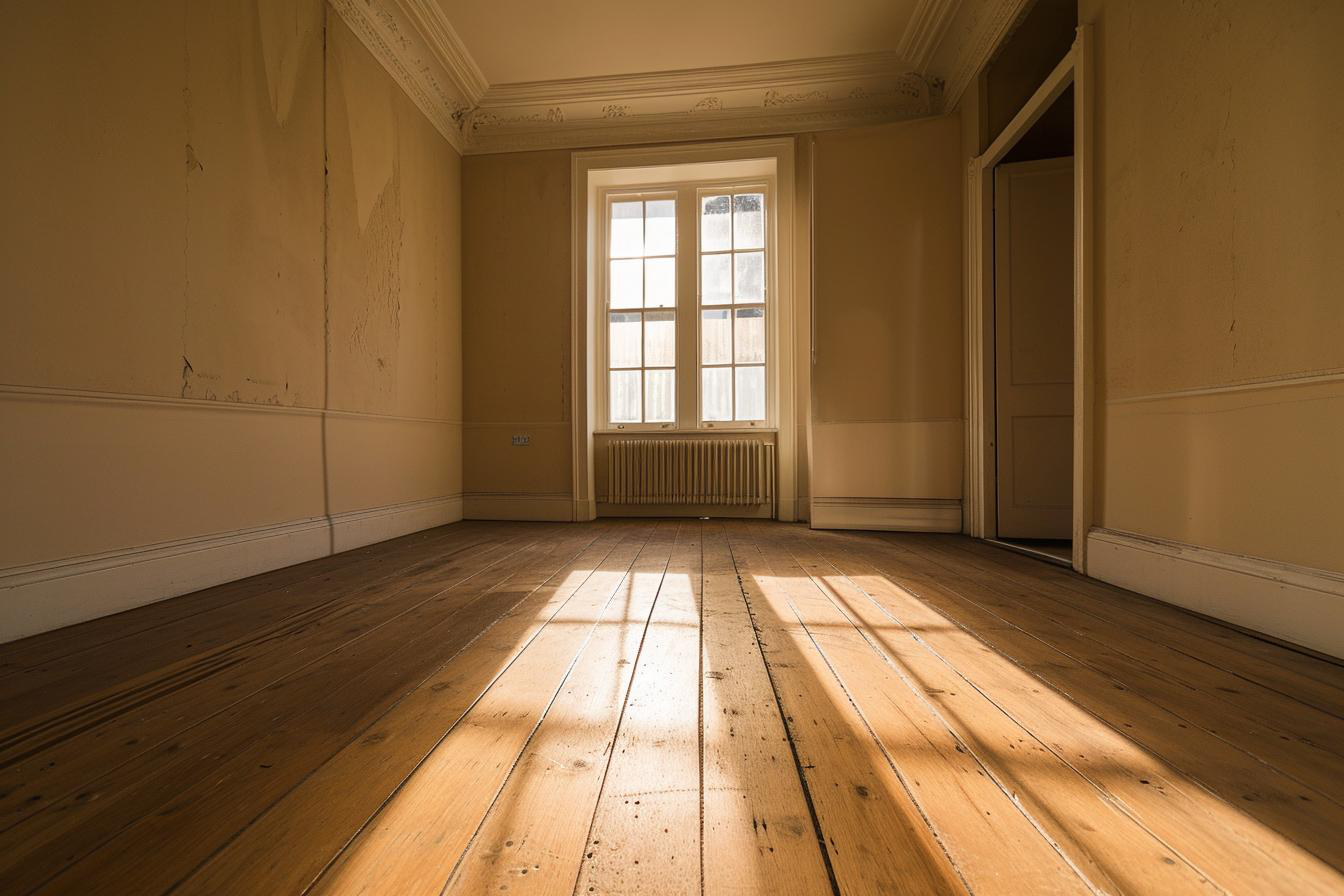

In [7]:
img = load_image('image_0.jpg')
img

The config attributes {'dropout': 0.0, 'sample_size': 32} were passed to ControlNetModel, but are not expected and will be ignored. Please verify your config.json configuration file.
text_encoder/model.safetensors not found


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet_inpaint.StableDiffusionControlNetInpaintPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


A Bauhaus-inspired living room with a sleek black leather sofa, a tubular steel coffee table exemplifying modernist design, and a geometric patterned rug adding a touch of artistic flair.
(1344, 896) (768, 512)


  0%|          | 0/50 [00:00<?, ?it/s]

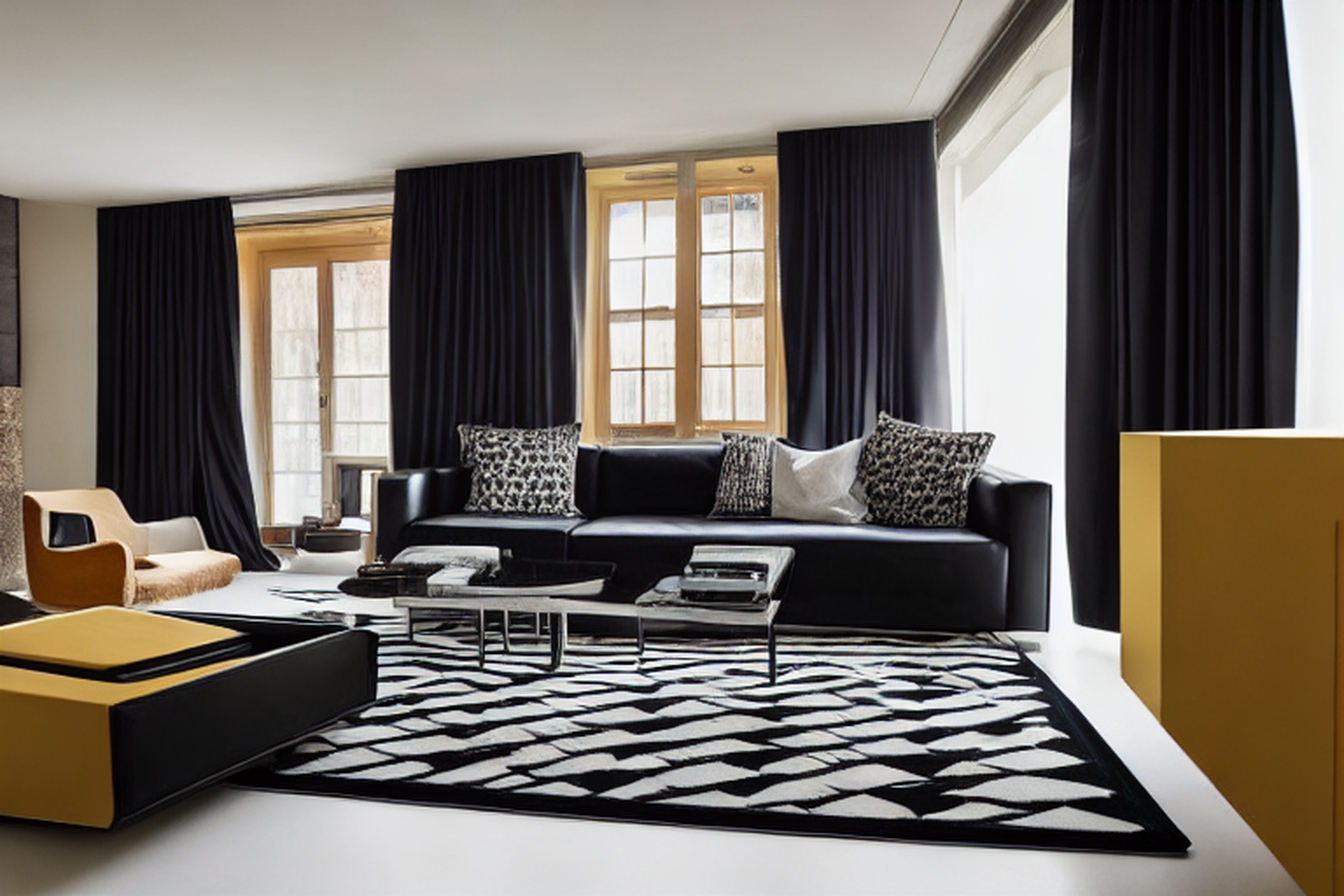

In [6]:
from diffusers.utils import load_image
prompt = "A Bauhaus-inspired living room with a sleek black leather sofa, a tubular steel coffee table exemplifying modernist design, and a geometric patterned rug adding a touch of artistic flair."
ctl = ControlNetDesignModel()
ctl.generate_design(img,prompt)